In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0
## Load Mentha Raw Data
**Source (MITAB): http://mentha.uniroma2.it/doDownload.php?file=2017-06-12_MITAB-2.5.zip**  
Downloaded: Dec 22, 2021
Last Updated: Dec 20, 2021  
Notes for processing: This is the file should contain only human-human protein interactions but this should be checked and filtered if needed.  
A Note about scoring: Mentha does have a score assigned for each interaction called the 'mentha-score', this will be the score we use to filter the network.

In [3]:
input_raw_v2 = pd.read_csv(wd+'Network_Data_Raw/Mentha/2021-12-20_MITAB-2.5.zip', sep=';')
print('Raw edge count in Mentha:', len(input_raw_v2))

Raw edge count in Mentha: 741337


In [4]:
# Keep only human-human interactions
input_human_v2 = input_raw_v2[(input_raw_v2["Taxon A"]==9606) & (input_raw_v2["Taxon B"]==9606)]
print('Human-Human only interactions in Mentha:', len(input_human_v2))

Human-Human only interactions in Mentha: 340916


In [5]:
genes_v2 = list(set(input_human_v2["Protein A"]).union(set(input_human_v2["Protein B"])))

## Convert Network Genes to symbol from UniProt Accession ID

In [6]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

19300 Valid Query Genes
0 Invalid Query Genes


In [7]:
uniprot_ids_v2, missing_v2 = gct.query_uniprot(valid_genes_v2, return_as_dict=False, target_fmt="ACC")

In [8]:
uniprot_mapping_v2 = pd.concat([uniprot_ids_v2, pd.DataFrame({"query":missing_v2, "ACC":missing_v2, "_score":0})])
uniprot_query_v2, valid_uniprot_v2, invalid_uniprot_v2 = gct.query_constructor(uniprot_mapping_v2["ACC"].tolist())

19394 Valid Query Genes
0 Invalid Query Genes


In [9]:
# Original 18932 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(uniprot_query_v2, scopes=scopes, fields=fields)


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]

19789 Matched query results
Batch query complete: 16.37 seconds


In [10]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)
match_list_final_v2 = match_list_v2.merge(uniprot_mapping_v2, left_on = ["query"], right_on=["ACC"])
match_list_final_v2 = match_list_final_v2.loc[:, ("query_y", "_id", "_score_x", "symbol", "notfound")]
match_list_final_v2.columns = ["query", "entrezgene", "_score", "symbol", "notfound"]

In [11]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_final_v2, valid_genes_v2)

Number of genes with multiple matches: 1479
Number of unmatched genes: 1256
Number of fully matched genes: 18037
Number of partially matched genes: 1263


## Construct Converted Network

In [12]:
edgelist_v2 = input_human_v2[["Protein A", "Protein B", "Score"]].drop_duplicates()

In [13]:
# Convert network edge list to symbol
edgelist_updated_v2 = gct.convert_edgelist(edgelist_v2, query_to_symbol_v2)

In [15]:
 
# Filter converted edge list
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2, weight_col="Score")

340916 input edges
3127 self-edges removed
7764 edges with un-mapped genes removed
4999 duplicate edges removed
Edge list filtered: 0.2 seconds
325026 Edges remaining


In [18]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_filt_v2, wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2021.sif', binary=False)

Edge list saved: 0.47 seconds


In [19]:
# Create filtered network
edgelist_90_v2 = dit.filter_weighted_network_sif(wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2021.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, save_path=wd+'/Processed_Data/Network_SIFs_Symbol/Mentha90_Symbol_2021.sif')

90.0% score: 0.454
25023 / 325026 edges retained


# Version 1.0 (original)
## Load Mentha Raw Data
**Source (MITAB): http://mentha.uniroma2.it/doDownload.php?file=2017-06-12_MITAB-2.5.zip**  
Downloaded: June 15, 2017  
Last Updated: June 12, 2017  
Notes for processing: This is the file should contain only human-human protein interactions but this should be checked and filtered if needed.  
A Note about scoring: Mentha does have a score assigned for each interaction called the 'mentha-score', this will be the score we use to filter the network.

In [20]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/Mentha/mentha_2017_06_12', sep='\t', header=None)
print('Raw edge count in Mentha:', len(input_raw))

Raw edge count in Mentha: 1114184


In [21]:
# Keep only human-human interactions
input_human = input_raw[(input_raw[9]=='taxid:9606(Homo sapiens)') & (input_raw[10]=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in Mentha:', len(input_human))

Human-Human only interactions in Mentha: 531726


In [22]:
# Extract gene list
genes = list(set(input_human[0]).union(set(input_human[1])))

## Convert Network Genes to symbol from UniProt Accession ID

In [23]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

18626 Valid Query Genes
0 Invalid Query Genes


In [24]:
uniprot_ids, missing = gct.query_uniprot(valid_genes, return_as_dict=False, target_fmt="ACC")

In [25]:
uniprot_mapping = pd.concat([uniprot_ids, pd.DataFrame({"query":missing, "ACC":missing, "_score":0})])
uniprot_query, valid_uniprot, invalid_uniprot = gct.query_constructor(uniprot_mapping["ACC"].tolist())

18725 Valid Query Genes
0 Invalid Query Genes


In [26]:
# Original 18932 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(uniprot_query, scopes=scopes, fields=fields)


100%|██████████| 19/19 [00:17<00:00,  1.07it/s]

19099 Matched query results
Batch query complete: 17.72 seconds


In [27]:
match_list = pd.DataFrame.from_dict(match_list)
match_list_final = match_list.merge(uniprot_mapping, left_on = ["query"], right_on=["ACC"])
match_list_final = match_list_final.loc[:, ("query_y", "_id", "_score_x", "symbol", "notfound")]
match_list_final.columns = ["query", "entrezgene", "_score", "symbol", "notfound"]

In [28]:
# Original 1198 without full matching results, 207 with multiple matches
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list_final, valid_genes)

Number of genes with multiple matches: 1417
Number of unmatched genes: 1103
Number of fully matched genes: 17517
Number of partially matched genes: 1109


## Construct Converted Network

In [29]:
edgelist = input_human[[0, 1, 14]].drop_duplicates().values.tolist()

In [30]:
# Format edge list by removing 'uniprot:' prefix from all interactors
edgelist = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1]), float(edge[2].split(':')[-1])] for edge in edgelist]

In [31]:
edgelist = pd.DataFrame(edgelist, columns = ["symbol n1", "symbol n2", "Score"])

In [32]:
# Convert network edge list to symbol
edgelist_updated = gct.convert_edgelist(edgelist, query_to_symbol)

In [33]:
# Original 
# 327857 input edges
# 3247 self-edges removed
# 8219 edges with un-mapped genes removed
# 53515 duplicate edges removed
# Edge list filtered: 1.61 seconds
# 262876 Edges remaining
## Why such a large change in duplicate edge removal??
# Filter converted edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated, weight_col="Score")

327857 input edges
2950 self-edges removed
6924 edges with un-mapped genes removed
55107 duplicate edges removed
Edge list filtered: 0.19 seconds
262876 Edges remaining


In [34]:
# Original 
# 327857 input edges
# 3247 self-edges removed
# 8219 edges with un-mapped genes removed
# 53515 duplicate edges removed
# Edge list filtered: 1.61 seconds
# 262876 Edges remaining
## Why such a large change in duplicate edge removal??
# Filter converted edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated, weight_col="Score")

327857 input edges
2950 self-edges removed
6924 edges with un-mapped genes removed
55107 duplicate edges removed
Edge list filtered: 0.19 seconds
262876 Edges remaining


In [35]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_filt, wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2017.sif', binary=False)

Edge list saved: 0.38 seconds


In [36]:
# Original
# 90.0% score: 0.454
# 22886 / 262876 edges retained
# Create filtered network
edgelist_90 = dit.filter_weighted_network_sif(wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2017.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, save_path=wd+'/Processed_Data/Network_SIFs_Symbol/Mentha90_Symbol_2017.sif')

90.0% score: 0.454
22983 / 262876 edges retained


# Changes

**Data Structure**  
Data provided now contains a header line:  
`Protein A	Gene A	Taxon A	Protein B	Gene B	Taxon B	Score	PMID`  

Data no longer contains:
* Source dataset IDs
* psi-mi


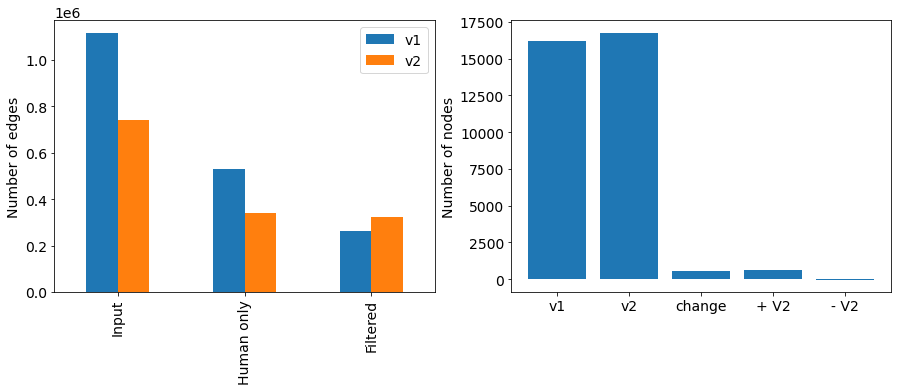

In [37]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_filt, edgelist_filt_v2, input_human, input_human_v2)

In [39]:
scores = pd.concat([edgelist_filt["Score"].describe(), edgelist_filt_v2["Score"].describe()], axis=1)
scores.columns = ["V1", "V2"]
scores

,V1,V2
count,262876.000000,325026.000000
mean,0.239967,0.233371
std,0.164356,0.155284
min,0.033000,0.033000
25%,0.126000,0.126000
50%,0.210000,0.210000
75%,0.286000,0.236000
max,1.000000,1.000000
